In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

## State

In [2]:
from typing import List, Annotated
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

class State(TypedDict):
    respuesta_final: str
    messages: Annotated[List[BaseMessage], add_messages]

class OutputState(TypedDict):
    respuesta_final: str

## Agente Supervisor

In [3]:
from typing import Literal
from typing_extensions import TypedDict
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.types import Command


# agente de almacén y el agente de compras
agents = ["storekeeper", "buyer"]

system_prompt = (
    "Eres un supervisor encargado de gestionar una conversación entre los"
    f" siguientes Agentes: {agents}. Dada la siguiente solicitud del usuario,"
    " responde indicando qué Agente debe actuar a continuación. Cada Agente"
    " realizará una tarea y responderá con sus resultados y estado. Cuando todos"
    " storekeeper encargado de brindar información sobre  el inventario."
    " buyer encargado de agregar productos al inventario"
    " hayan terminado, responde con FINISH."
)

class RouterOutput(TypedDict):
    """Agente al que se debe dirigir a continuación. Si no se necesitan más Agente, dirigir a FINISH."""
    next: Literal["storekeeper", "buyer", "FINISH"]

llm = ChatOpenAI(model="gpt-4o")

def supervisor_node(state: State) -> Command[Literal["storekeeper", "buyer", "__end__"]]:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(RouterOutput).invoke(messages)
    goto = response["next"]
    if goto == "FINISH":
        goto = END

    return Command(update={
            "respuesta_final":state["messages"][-1].content
            }, goto=goto)




## Agente del almacén

In [4]:
from src.tools.fake_api import init_db, fake_request

init_db("src/data")

### tools

In [5]:
def get_all_products():
    """Se obtienen todos los productos del almacén."""

    response = fake_request("GET", "/purchases")
    return response


In [6]:
def get_product_by_name(product_name):
    """
    Busca producto por medio de nombre en el inventario.


    Parámetros:
        product_name (str): Nombre del producto a buscar.

    Retorno:
        dict: Detalles del producto si existe, o un mensaje indicando que no se encontró.    
    """
    response = fake_request("GET", f"/products/search/{product_name}")
    return response

In [7]:
from langgraph.prebuilt import create_react_agent
tools = [get_all_products, get_product_by_name]
storekeeper_agent = create_react_agent(llm, tools=tools)

## Agente de Compras

In [8]:
def add_new_product(product_name, quantity, price):
    """
    Registra productos nuevos para el inventario.

    Parámetros:
        product_name (str): Nombre del producto a registrar.
        quantity (int): Cantidad del producto a registrar.
        price (float): Precio unitario del producto a registrar.

    Retorno:
        dict: Mensaje de confirmación con los detalles del producto a registrar.
    """

    new_product = {"product_name": product_name, "quantity": quantity, "price": price}
    response = fake_request("POST", "/purchases/add", data=new_product)

    return response

In [9]:
tools_2 = [add_new_product]
buyer_agent = create_react_agent(llm, tools=tools_2)

## MultiAgente Flujo

In [10]:
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import MemorySaver


def storekeeper_node(state: State) -> Command[Literal["supervisor"]]:
    result = storekeeper_agent.invoke(state)
    return Command(
        update={
            "messages": HumanMessage(content=result["messages"][-1].content, name="storekeeper")  
        },
        goto="supervisor",
    )


def buyer_node(state: State) -> Command[Literal["supervisor"]]:
    result = buyer_agent.invoke(state)
    return Command(
        update={
            "messages": HumanMessage(content=result["messages"][-1].content, name="buyer")
        },
        goto="supervisor",
    )

checkpointer = MemorySaver()

builder = StateGraph(State, output=OutputState)

builder.add_node("supervisor", supervisor_node)
builder.add_node("storekeeper", storekeeper_node)
builder.add_node("buyer", buyer_node)

builder.add_edge(START, "supervisor")

graph = builder.compile(checkpointer=checkpointer)

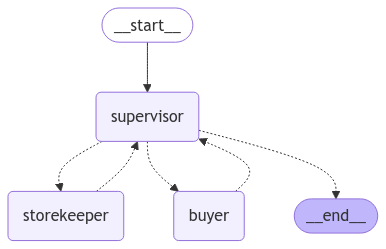

In [11]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
config = {"configurable": {"thread_id": "5"}}
mensaje = "quiero agregar 3 Polos Rojos con precio unitario de 20.12"
for s in graph.stream(
    {"messages": [("user", mensaje)]}, subgraphs=True, config=config):
    print(s)
    print("-----")

((), {'supervisor': {'respuesta_final': 'quiero agregar 3 Polos Rojos con precio unitario de 20.12'}})
-----
(('buyer:40e95832-6088-ee3f-971f-973eccfd3e6e',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ZOJ4sXoVXpWgO3hFtkxtRFeY', 'function': {'arguments': '{"product_name":"Polos Rojos","quantity":3,"price":20.12}', 'name': 'add_new_product'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 224, 'total_tokens': 255, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_50cad350e4', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-dcb3be7a-8905-4b2e-8f91-a6f9b02761fd-0', tool_calls=[{'name': 'add_new_product', 'args': {'product_name': 'Polos Rojos', 'qua

In [15]:
config = {"configurable": {"thread_id": "7"}}
mensaje = "dame el detalle de los productos en el almacen"
response = graph.invoke({"messages": [("user", mensaje)]}, subgraphs=True, config=config)

print(response[1]["respuesta_final"])

Aquí tienes el detalle de los productos en el almacén:

1. **PANTALONES LEVY**
   - Cantidad: 2
   - Precio: $25.12
   - Fecha de registro: 17 de enero de 2025, 04:33:30

2. **POLOS ROJOS**
   - Cantidad: 3
   - Precio: $20.12
   - Fecha de registro: 17 de enero de 2025, 04:33:52

3. **PANTALONES LEVY**
   - Cantidad: 2
   - Precio: $25.12
   - Fecha de registro: 17 de enero de 2025, 04:33:57 (parece ser un registro duplicado)

4. **POLOS ROJOS**
   - Cantidad: 3
   - Precio: $20.12
   - Fecha de registro: 17 de enero de 2025, 04:33:58 (otro registro que parece duplicado)

Parece que hay duplicación en los registros, revisa por favor si es intencional.


In [36]:
from langchain.globals import set_debug

set_debug(False)

In [ ]:
config = {"configurable": {"thread_id": "7"}}
mensaje = "dime cuantos polos rojos hay"
response = graph.invoke({"messages": [("user", mensaje)]}, subgraphs=True, config=config)

print(response[1]["respuesta_final"])

In [ ]:
os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_ENDPOINT"]="https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"]="<API_KEY>"

In [ ]:
from langfuse.callback import CallbackHandler
langfuse_handler = CallbackHandler(
    public_key="<PUBLIC_KEY>",
    secret_key="<SECRET_KEY>",
    host="https://us.cloud.langfuse.com"
)


config = {"configurable": {"thread_id": "7"}, "callbacks": [langfuse_handler]}
mensaje = "dime cuantos polos rojos hay"
response = graph.invoke({"messages": [("user", mensaje)]}, subgraphs=True, config=config)

print(response[1]["respuesta_final"])